# Analyse File

In [63]:
#General imports
import sys
import pandas as pd
import numpy as np
import seaborn as sns

#Project specific imports
sys.path.insert(0, r'..\Data')
from MyPostgreSQL import MyPostgreSQL


Disconnected: the connection is now closed.
Disconnected: the connection is now closed.


In [64]:
def getSMA(days, ticker):
    "Return a Dataframe of the moving average of <days> (input value) samples on table <ticker> (input value)"
    MyClass = MyPostgreSQL()
    (conn, cursor) = MyClass.getConnCursor()

    query = f""" 
            SELECT date, adj_close, AVG(adj_close)
            OVER(
                ORDER BY date
                ROWS BETWEEN {days-1} PRECEDING AND CURRENT ROW
            ) AS SMA
            FROM {ticker};
            """
    
    cursor.execute(query)
    
    rows = cursor.fetchall()
    df = pd.DataFrame(rows, columns=['date', 'adj_close', f'MA{days}'])
    df.set_index('date', inplace=True)
    return df

number = 3
df = getSMA(number, 'AAPL')



Connecting to database server...
Connection established to:  ('PostgreSQL 14.0, compiled by Visual C++ build 1914, 64-bit',)
Constructor: The ticker is set to "AAPL" and absolut data path is "C:\Users\david\OneDrive\Code\StockAnalysis\Data\SP500\"
Disconnected: the connection is now closed.


In [65]:
df_50 = getSMA(50, 'AAPL')
df_200 = getSMA(200, 'AAPL')

Connecting to database server...
Connection established to:  ('PostgreSQL 14.0, compiled by Visual C++ build 1914, 64-bit',)
Constructor: The ticker is set to "AAPL" and absolut data path is "C:\Users\david\OneDrive\Code\StockAnalysis\Data\SP500\"
Disconnected: the connection is now closed.
Connecting to database server...
Connection established to:  ('PostgreSQL 14.0, compiled by Visual C++ build 1914, 64-bit',)
Constructor: The ticker is set to "AAPL" and absolut data path is "C:\Users\david\OneDrive\Code\StockAnalysis\Data\SP500\"
Disconnected: the connection is now closed.


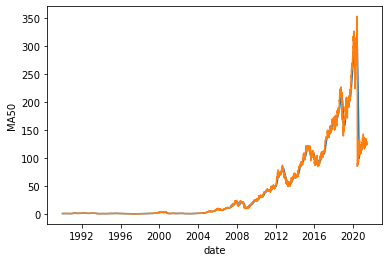

In [69]:

sns.lineplot(x=df_50.index, y=df_50['MA50'])
sns.lineplot(x=df_50.index, y=df_50['adj_close'])


In [67]:
query = """ 
        SELECT COUNT(*) as num
        FROM aapl;
        """

MyClass = MyPostgreSQL()
(conn, cursor) = MyClass.getConnCursor()
cursor.execute(query)
data = cursor.fetchone()
print( 'Data is ', data)

Connecting to database server...
Connection established to:  ('PostgreSQL 14.0, compiled by Visual C++ build 1914, 64-bit',)
Constructor: The ticker is set to "AAPL" and absolut data path is "C:\Users\david\OneDrive\Code\StockAnalysis\Data\SP500\"
Disconnected: the connection is now closed.
Data is  (7922,)
